# Notebook to solve inverse problems on general graphs

## Load modules and necessary functions

In [13]:
#import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

import jax.numpy as jnp
from jax import random, vmap
import numpy as np

import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='true'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.5'

import sys
from src.graph import Example0, Example1, Example2, Example3, Example4, Example5, Example6, Example7, Example8, Example7Ext, Example7Ext2
from src.quantumGraphSolverFVM import QuantumGraphSolverFVM
from src.dataHandling import load_final_model, load_best_model
from src.GPs import get_sample_fns, RBF
from src.networks_velocity import modified_MLP, MLP, FF_MLP, PI_DeepONet

import pickle
from datetime import datetime
import jax
import optax

from jax.example_libraries import optimizers


## Set up global parameters

In [32]:
FVM_NT = 2000
FVM_NX = 1000

# Choose an appropriate FVM_NX
assert FVM_NX % 100 == 0
fnx = round(FVM_NX/100)
assert FVM_NT % 100 == 0
fnt = round(FVM_NT/100)

EPS = 0.1

N_DATA_BC = 100
N_DATA_INIT = 100

x_sensor_bc = jnp.linspace(0, 1, N_DATA_BC+1)
x_sensor_init = jnp.linspace(0, 1, N_DATA_INIT+1)
n_sensor_bc =  N_DATA_BC+1
n_sensor_init = N_DATA_INIT+1

# Locations of residual values inside domain
T_RES, X_RES = jnp.meshgrid(jnp.linspace(0, 1, FVM_NT + 1),
                            jnp.linspace(0, 1, FVM_NX + 1))

TX = jnp.hstack([T_RES.reshape((-1,1)), X_RES.reshape((-1,1))])
TX_small = jnp.hstack([l.reshape((-1, 1)) for l in jnp.meshgrid(
    jnp.linspace(0, 1, N_DATA_BC + 1),
    jnp.linspace(0, 1, N_DATA_INIT + 1))])

# Change GP parameters to avoid inverse crime, original values
# TODO could be random
# LENGTH_SCALE = 0.5 # original
# N = 512 # original
LENGTH_SCALE = 0.4
N = 468

sample_u_in_fn, sample_u_out_fn, sample_u_init_fn = get_sample_fns(N=N, length_scale=LENGTH_SCALE)


def fvm_solve(graph, nx=200, nt = 1000):
    fvm_solver = QuantumGraphSolverFVM(graph)
    v = fvm_solver.solve(nx=nx + 1, nt=nt + 1)
    v0 = np.array([fvm_solver.get_u_edge(v.T, i).T for i in range(graph.ne)])
    return v0

def draw_random_velocity(graph, key, vmin=0.5, vmax=2.):
    v_current = graph.v
    return random.uniform(key, v_current.shape, minval=vmin, maxval=vmax)

# Prepare certain time-space points where model is evaluated
N = 100
tx_in = jnp.hstack([jnp.linspace(0, 1, N + 1)[:, None], jnp.ones((N + 1, 1))])
tx_out = jnp.hstack([jnp.linspace(0, 1, N + 1)[:, None], jnp.zeros((N + 1, 1))])

# Prepare certain time-space points where model is evaluated
n_rnd = 200
tx_rnd = random.uniform(random.key(1),(n_rnd,2))
tx_mid = jnp.hstack([jnp.linspace(0, 1, N + 1)[:, None], .5*jnp.ones((N + 1, 1))])


## Load model parameters for PI DeepONet model

In [118]:
# These parameters are investigated
#N_WIDTH, MODE = 100, 0
#N_WIDTH, MODE = 100, 1
#N_WIDTH, MODE = 100, 2
#N_WIDTH, MODE = 200, 0
#N_WIDTH, MODE = 200, 1
N_WIDTH, MODE = 200, 2


NOISE = 0.01

FLOW_APPROACH = 'rbf'
INIT_APPROACH = 'rbf'
#INIT_APPROACH = None

VEL_APPROACH = 'scalar'
#VEL_APPROACH = None


SOLVER_N_ITER = 5000
L2_abs_loss = []
L2_rel_loss = []
Linf_loss = []
init_L2_abs_loss = []
init_L2_rel_loss = []
vel_l2_abs_loss = []
vel_l2_rel_loss = []


# We evaluate the inference error for the following example
# Various test settings are implemented, feel free to define your
# own examples in src.graph

mode= 3
if mode == 0:
    graph = Example2(eps=EPS)
if mode == 1:
    graph = Example5(eps=EPS, n_edges=3)
if mode == 2:
    graph = Example7(eps=EPS)
elif mode == 3:
    n_in = 3
    n_out = 3
    graph = Example7Ext2(n=34*3, n_in = n_in, n_out=n_out, eps=EPS)
elif mode == 5:
    n_in = 5
    n_out = 5
    graph = Example7Ext2(n=34*5, n_in = n_in, n_out=n_out, eps=EPS)
elif mode == 10:
    n_in = 5
    n_out = 5
    graph = Example7Ext2(n=34*10, n_in = n_in, n_out=n_out, eps=EPS)

m = 304

params_inflow, params_inner, params_outflow = load_best_model(N_WIDTH, MODE, prefix='.')

# Initialize model
branch_layers = [m, N_WIDTH, N_WIDTH, N_WIDTH, N_WIDTH, N_WIDTH, N_WIDTH, N_WIDTH]
trunk_layers =  [2, N_WIDTH, N_WIDTH, N_WIDTH, N_WIDTH, N_WIDTH, N_WIDTH, N_WIDTH]
model = PI_DeepONet(Example0(eps=EPS), branch_layers, trunk_layers, trunk_net=FF_MLP)

Loaded  ./final_params/params_inflow_mode_2_width_200_split_8_epochs_20000_loss_6.64e-04_FF_best_01-28-2025-163740_FF.pkl
Loaded  ./final_params/params_inner_mode_2_width_200_split_8_epochs_20000_loss_2.62e-04_FF_best_01-29-2025-074810_FF.pkl
Loaded  ./final_params/params_outflow_mode_2_width_200_split_8_epochs_20000_loss_6.30e-04_FF_best_01-29-2025-041253_FF.pkl


### Plot graph

Text(0.5, 1.0, 'Graph with 306 edges; 102 inner, 3 inflow and 3 outflow nodes')

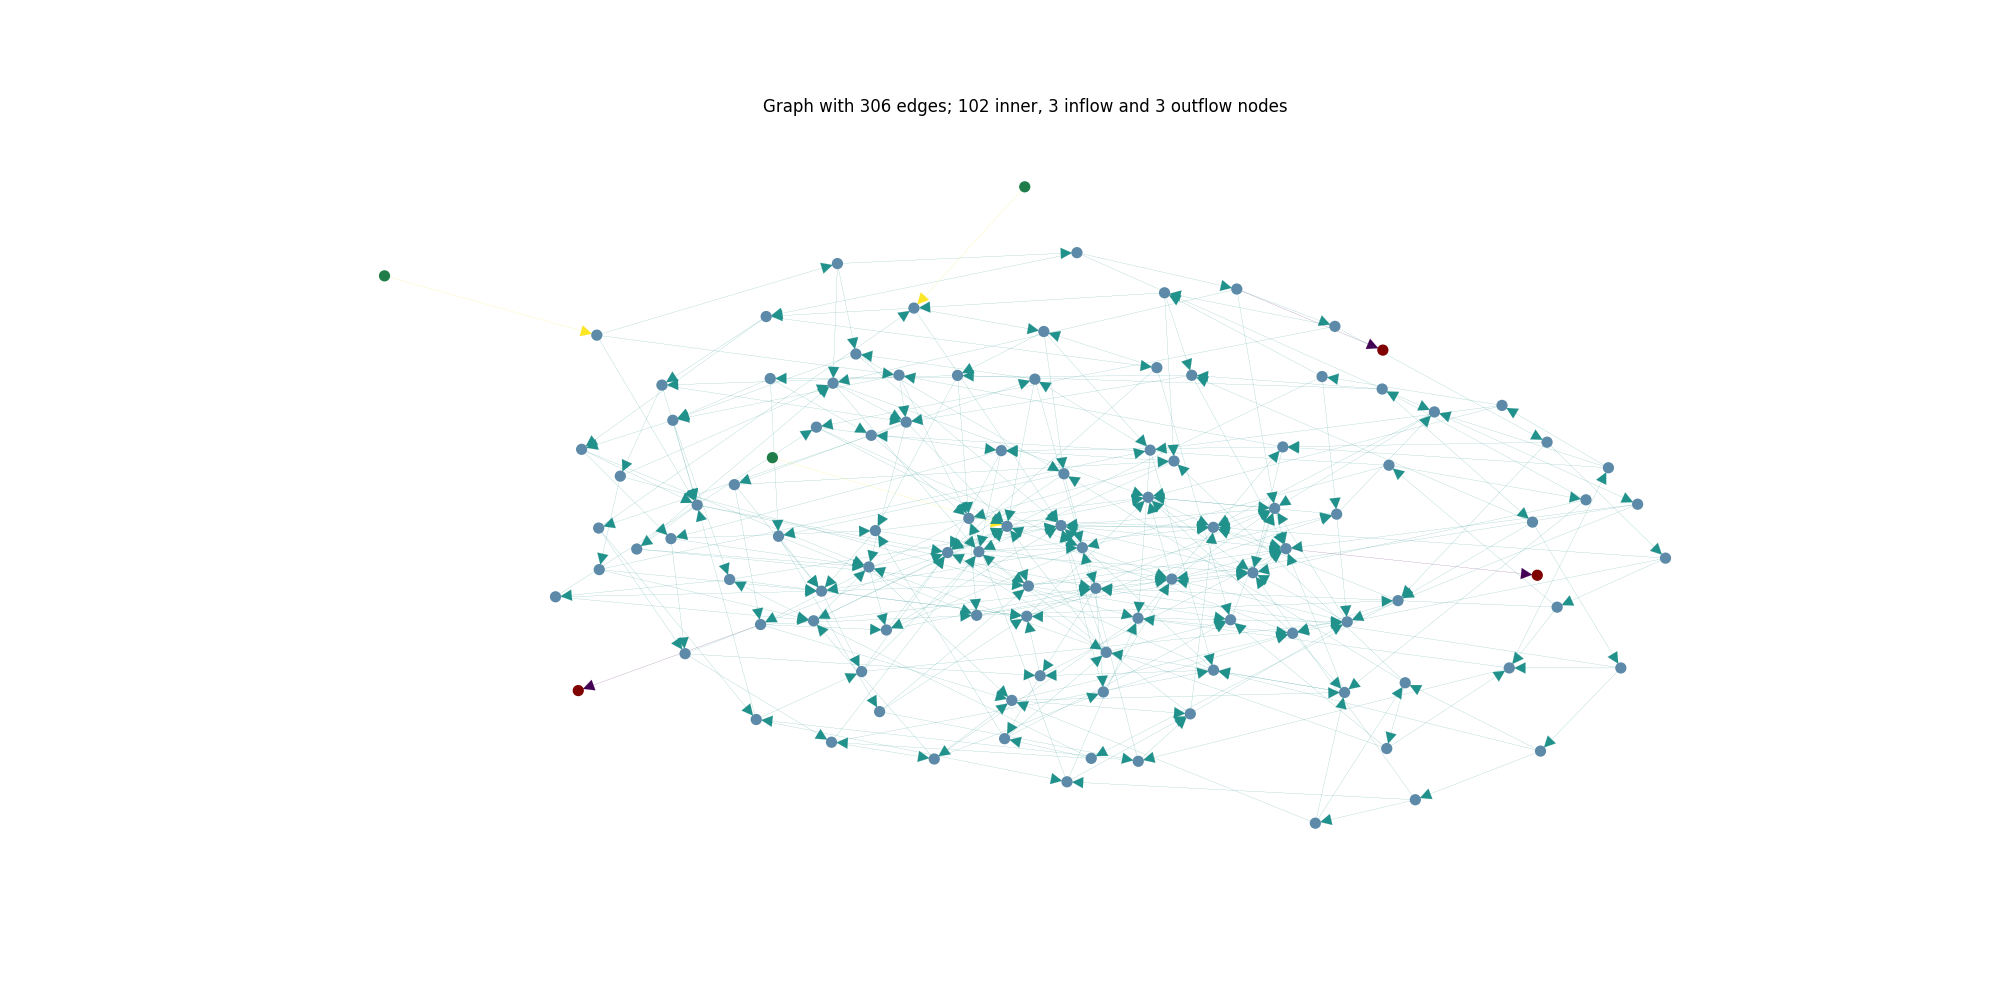

In [119]:
fig = plt.figure(figsize=(20,10))

sfig = f'Graph with {graph.ne} edges; {len(graph.innerVertices)} inner, {n_in} inflow and {n_out} outflow nodes';
ax = plt.gca()
graph.plotGraph(ax=ax, node_size=50, with_labels=False, width=0.1, arrowsize=20)
ax.set_title(sfig)

#plt.savefig(f'./figs/graph_{graph.ne}_edges.png', dpi=200)

## Prepare solution on graph

### Determine vertex-edge connectivity table

In [120]:
# Vertex-edge list
vertex_edge_list = []
glob_inner_idx = 0
for vidx in graph.innerVertices:
    for eidx in graph.Vin[vidx]: # Incoming edges in vertex vidx
        #print(f'Incoming edge {eidx} into vertex {vidx} is a ')
        if graph.E[eidx][0] in graph.inflowNodes:
            #print(f'\t INFLOW EDGE')
            vertex_edge_list.append([vidx, glob_inner_idx, eidx, -1, -1])
        else:
            #print(f'\t INNER EDGE')
            vertex_edge_list.append([vidx, glob_inner_idx, eidx, -1, 0])
    for eidx in graph.Vout[vidx]: # Outflowing edges from vertex vidx
        #print(f'Outgoing edge {eidx} from vertex {vidx} is a ')
        if graph.E[eidx][1] in graph.outflowNodes:
            #print(f'\t OUTFLOW EDGE')
            vertex_edge_list.append([vidx, glob_inner_idx, eidx, 1, 1])
        else:
            #print(f'\t INNER EDGE')
            vertex_edge_list.append([vidx, glob_inner_idx, eidx, 1, 0])
    glob_inner_idx += 1
vertex_edge_list = np.vstack(vertex_edge_list)
n_params = vertex_edge_list.shape[0]

# Inner vertex index -> vertex-edge list index
ve_vidx = []
for vidx in range(len(graph.innerVertices)):
    ve_vidx.append(jnp.argwhere(vertex_edge_list[:,1] == vidx).flatten())

# Edge list
edge_list = []
inner_idx = 0

for i, e in enumerate(graph.E): # All edges
    #print(f'Edge {e} is a ')
    inflow_idx = np.where(e[0] == graph.inflowNodes)[0]
    outflow_idx = np.where(e[1] == graph.outflowNodes)[0]
    if len(inflow_idx) > 0:
        #print(f'\t INFLOW EDGE')
        edge_list.append([i, inflow_idx[0], *e, -1])
    elif len(outflow_idx) > 0:
        #print(f'\t OUTFLOW EDGE')
        edge_list.append([i, outflow_idx[0], *e, 1])
    else:
        #print(f'\t INNER EDGE')
        edge_list.append([i, inner_idx, *e, 0])
        inner_idx += 1
edge_list = np.vstack(edge_list)

n_inflow_edges = np.sum(edge_list[:,-1]==-1)
n_outflow_edges = np.sum(edge_list[:,-1]==1)
n_inner_edges = np.sum(edge_list[:,-1]==0)
n_edges = n_inflow_edges + n_outflow_edges + n_inner_edges

### Polynomial and RBF approach for flows

In [121]:
if FLOW_APPROACH == 'poly':

    deg_flow = 3
    def draw_initial_beta(key):
        return random.normal(key, shape=(n_params, deg_flow + 1)) * 0.01

    def beta_to_z_flow(beta):
        return jnp.vstack([jnp.polyval(b, x_sensor_bc).reshape((1,101)) for b in beta])
        
    
elif FLOW_APPROACH == 'rbf':

    # Parameters for RBF interpolation
    n_rbf_flow = 10
    
    rbf_output_scale = 1.
    rbf_length_scale = 0.2
    rbf_jitter = 1e-10
    
    def draw_initial_beta(key):
        return random.normal(key, shape=(n_params, n_rbf_flow)) * 0.01

    x_rbf_flow = jnp.linspace(0, 1, n_rbf_flow)
    K_flow = RBF(x_sensor_bc.reshape((n_sensor_bc, 1)),
                 x_rbf_flow.reshape((-1, 1)),
                 (rbf_output_scale, rbf_length_scale))
    
    def beta_to_z_flow(beta):
        return jnp.vstack([jnp.dot(K_flow, b).reshape((1, n_sensor_bc)) for b in beta])


# Initial condition identification
if INIT_APPROACH == 'poly':
    deg_init = 5
    
    def draw_initial_gamma(key):
        return random.normal(key, shape=(n_edges, deg_init + 1)) * 0.01
    
        
    def gamma_to_z_init(gamma):
        return jnp.vstack([jnp.polyval(b, x_sensor_init).reshape((1,101)) for b in gamma])
        
elif INIT_APPROACH == 'rbf':
    # Parameters for RBF interpolation
    n_rbf_init = 20
    
    rbf_output_scale = 1.
    rbf_length_scale = 0.2
    rbf_jitter = 1e-10
    
    def draw_initial_gamma(key):
        return random.normal(key, shape=(n_edges, n_rbf_init)) * 0.01

        
    x_rbf_init = jnp.linspace(0, 1, n_rbf_init)
    K_init = RBF(x_sensor_bc.reshape((n_sensor_bc, 1)),
                 x_rbf_init.reshape((-1, 1)),
                 (rbf_output_scale, rbf_length_scale))
    
    def gamma_to_z_init(gamma):
        return jnp.vstack([jnp.dot(K_init, b).reshape((1,101)) for b in gamma])

else: # No identification of initial condition
    def draw_initial_gamma(key):
        return u_init_list
        
    def gamma_to_z_init(gamma):
        return u_init_list

# Velocity identification
if VEL_APPROACH == 'scalar':
    def draw_initial_vel(key):
        return random.normal(key, shape=(n_edges,)) * 0.01 + 1.
        
    def vel_to_z_vel(x):
        return x

else: # No identification of velocity    
    def draw_initial_vel(key):
        return vel
        
    def vel_to_z_vel(x):
        return vel

# Draw and transform all unknows
def draw_initial_eta(key):
    key = random.split(key, 3)
    return [draw_initial_beta(key[0]), draw_initial_gamma(key[1]), draw_initial_vel(key[2])]

def eta_to_zeta(eta):
    return [beta_to_z_flow(eta[0]), gamma_to_z_init(eta[1]), vel_to_z_vel(eta[2])]

### Define loss function for inverse problem

In [122]:
# Prepare evaluation of measurement data
predict_all = vmap(model.flux_net, (None, None, 0, 0))
predict_flux = vmap(predict_all, (None, 0, None, None))

inflow_edges = edge_list[edge_list[:,-1] == -1, :]
inner_edges = edge_list[edge_list[:,-1] == 0, :]
outflow_edges = edge_list[edge_list[:,-1] == 1, :]

def predict_inflow_flux(z):
    fv = jnp.stack(predict_flux(params_inflow, z[inflow_edges[:, 0],:], tx_mid[:, 0], tx_mid[:, 1]))
    return jnp.split(fv, 2)

def predict_inner_flux(z):
    fv = jnp.stack(predict_flux(params_inner, z[inner_edges[:, 0],:], tx_mid[:, 0], tx_mid[:, 1]))
    return jnp.split(fv, 2)
    
def predict_outflow_flux(z):
    fv = jnp.stack(predict_flux(params_outflow, z[outflow_edges[:, 0],:], tx_mid[:, 0], tx_mid[:, 1]))
    return jnp.split(fv, 2)

incoming_inflow_idx = jnp.where(vertex_edge_list[:, -1] == -1)[0]
incoming_inner_idx = jnp.where((vertex_edge_list[:, -1] == 0) * (vertex_edge_list[:, 3] == -1))[0]
outgoing_inner_idx = jnp.where((vertex_edge_list[:, -1] == 0) * (vertex_edge_list[:, 3] == 1))[0]
outgoing_outflow_idx = jnp.where(vertex_edge_list[:, -1] == +1)[0]

# Prepare evaluation of vertex-edge data

n_ve = vertex_edge_list.shape[0]
n_tx = tx_in.shape[0]

ve_incoming_inflow = vertex_edge_list[incoming_inflow_idx, :]
ve_incoming_inner = vertex_edge_list[incoming_inner_idx, :]
ve_outgoing_inner = vertex_edge_list[outgoing_inner_idx, :]
ve_outgoing_outflow = vertex_edge_list[outgoing_outflow_idx, :]

n_incoming_inflow = ve_incoming_inflow.shape[0]
n_incoming_inner = ve_incoming_inner.shape[0]
n_outgoing_inner = ve_outgoing_inner.shape[0]
n_outgoing_outflow = ve_outgoing_outflow.shape[0]

def predict_ve_incoming_inflow(z):
    f, v = jnp.split(jnp.stack(predict_flux(params_inflow, z[ve_incoming_inflow[:, 2],:], tx_in[:, 0], tx_in[:, 1])), 2)
    return f.squeeze(axis=0) * ve_incoming_inflow[:, 3].reshape((-1,1)), v.squeeze(axis=0)
    
def predict_ve_incoming_inner(z):
    f, v = jnp.split(jnp.stack(predict_flux(params_inner, z[ve_incoming_inner[:, 2],:], tx_in[:, 0], tx_in[:, 1])), 2)
    return f.squeeze(axis=0) * ve_incoming_inner[:, 3].reshape((-1,1)), v.squeeze(axis=0)
    
def predict_ve_outgoing_inner(z):
    f, v = jnp.split(jnp.stack(predict_flux(params_inner, z[ve_outgoing_inner[:, 2],:], tx_out[:, 0], tx_out[:, 1])), 2)
    return f.squeeze(axis=0) * ve_outgoing_inner[:, 3].reshape((-1,1)), v.squeeze(axis=0)
    
def predict_ve_outgoing_outflow(z):
    f, v = jnp.split(jnp.stack(predict_flux(params_outflow, z[ve_outgoing_outflow[:, 2],:], tx_out[:, 0], tx_out[:, 1])), 2)
    return f.squeeze(axis=0) * ve_outgoing_outflow[:, 3].reshape((-1,1)), v.squeeze(axis=0)

In [123]:
@jax.jit
def f_u_new(u_base):
    ve_incoming_inflow_flux, ve_incoming_inflow_vals = predict_ve_incoming_inflow(u_base)
    ve_incoming_inner_flux, ve_incoming_inner_vals = predict_ve_incoming_inner(u_base)
    ve_outgoing_inner_flux, ve_outgoing_inner_vals = predict_ve_outgoing_inner(u_base)
    ve_outgoing_outflow_flux, ve_outgoing_outflow_vals = predict_ve_outgoing_outflow(u_base)
    
    Xvals = jnp.empty((n_ve, n_tx))
    Xvals = Xvals.at[incoming_inflow_idx].set(ve_incoming_inflow_vals)
    Xvals = Xvals.at[incoming_inner_idx].set(ve_incoming_inner_vals)
    Xvals = Xvals.at[outgoing_inner_idx].set(ve_outgoing_inner_vals)
    Xvals = Xvals.at[outgoing_outflow_idx].set(ve_outgoing_outflow_vals)
    
    Xflux = jnp.empty((n_ve, n_tx))
    Xflux = Xflux.at[incoming_inflow_idx].set(ve_incoming_inflow_flux)
    Xflux = Xflux.at[incoming_inner_idx].set(ve_incoming_inner_flux)
    Xflux = Xflux.at[outgoing_inner_idx].set(ve_outgoing_inner_flux)
    Xflux = Xflux.at[outgoing_outflow_idx].set(ve_outgoing_outflow_flux)
    
    
    loss_cont = 0
    loss_flux = 0
    for vidx in range(len(graph.innerVertices)):
        scaling = len(ve_vidx[vidx])
        loss_cont += jnp.sum(jnp.square(jnp.diff(Xvals[ve_vidx[vidx], :], axis=0))) / scaling
        loss_flux += jnp.sum(jnp.square(jnp.sum(Xflux[ve_vidx[vidx], :], axis=0))) / scaling
    inflow_flux, inflow_vals = predict_inflow_flux(u_base)
    inner_flux, inner_vals = predict_inner_flux(u_base)
    outflow_flux, outflow_vals = predict_outflow_flux(u_base)
    
    loss_meas_val = 0
    loss_meas_val += jnp.sum(jnp.square(inflow_flux - fvm_flow_mid[inflow_edges[:, 0]])) 
    loss_meas_val += jnp.sum(jnp.square(inner_flux - fvm_flow_mid[inner_edges[:, 0]]))
    loss_meas_val += jnp.sum(jnp.square(outflow_flux - fvm_flow_mid[outflow_edges[:, 0]]))
    
    loss_meas_flux = 0
    loss_meas_flux += jnp.sum(jnp.square(inflow_vals - fvm_v_mid[inflow_edges[:, 0]])) 
    loss_meas_flux += jnp.sum(jnp.square(inner_vals - fvm_v_mid[inner_edges[:, 0]]))
    loss_meas_flux += jnp.sum(jnp.square(outflow_vals - fvm_v_mid[outflow_edges[:, 0]]))

    # Averaging
    loss_meas_val /= graph.ne
    loss_cont /= len(graph.innerVertices)
    loss_flux /= len(graph.innerVertices)
    loss_meas_flux /= graph.ne
    
    return loss_cont, loss_flux, loss_meas_val, loss_meas_flux


### Function `z_to_u_base`
This function plugs the parameters $z \in \mathbb{R}^{101\times n_\text{params}}$ to its correct position in the list of sensor values.

In [124]:
def zeta_to_u_base(zeta, u_in, u_out):
    z, u_init_list, vel = zeta
    u_list = []
    in_offset = n_inflow_edges
    out_offset = 2 * n_inner_edges + n_inflow_edges
    for e in edge_list:
        if e[-1] == -1: # Inflow edge
            u_list.append(jnp.hstack([u_in[e[1]],
                                      z[e[1]],
                                      u_init_list[e[0]],
                                      vel[e[0]]]))
        elif e[-1] == 0: # Inner edge
            u_list.append(jnp.hstack([z[2*e[1] + in_offset],
                                      z[2*e[1] + in_offset + 1],
                                      u_init_list[e[0]],
                                      vel[e[0]]]))
        else:
            u_list.append(jnp.hstack([z[out_offset + e[1]],
                                      u_out[e[1]],
                                      u_init_list[e[0]],
                                      vel[e[0]]]))
    ret = jnp.vstack(u_list)
    return ret



@jax.jit
def f_eta(eta, u_in, u_out):
    return f_u_new(zeta_to_u_base(eta_to_zeta(eta), u_in, u_out))

@jax.jit
def f(eta, u_in, u_out):
    fb = f_eta(eta, u_in, u_out)
    return fb[0] + fb[1] + fb[2] + fb[3]
    
val_grad_f = jax.jit(jax.value_and_grad(f,0))

## Everything below is key specific

In [125]:
# Initialize global key
global_key = random.key(0)
n = 1

In [126]:
global_key, key = random.split(global_key, 2)

### Draw random conditions

In [127]:
# Split key
key, inflow_key, outflow_key, init_key, vel_key, eta_key, noise_key = random.split(key, 7)

# Generate GPs for inflow conditions
inflow_fn_list = [sample_u_in_fn(s) for s in random.split(inflow_key, len(graph.inflowNodes))]

# Generate GPs for outflow conditions
outflow_fn_list = [sample_u_out_fn(s) for s in random.split(outflow_key, len(graph.outflowNodes))]

# Generate GP for initial condition
init_cond_fn_list = [sample_u_init_fn(s) for s in random.split(init_key, graph.ne)]

# Set up inflow conditions for FVM solver
def dirichletAlpha(x):
    alpha = np.zeros(graph.n_v)
    alpha[graph.inflowNodes] = np.array([inflow_fn(x) for inflow_fn in inflow_fn_list])
    return alpha

# Set up outflow conditions for FVM solver
def dirichletBeta(x):
    beta = np.zeros(graph.n_v)
    beta[graph.outflowNodes] = np.array([outflow_fn(x) for outflow_fn in outflow_fn_list])
    return beta
    
# Set up initial conditions for FVM solver
initial_cond = lambda x: np.array([init_cond_fn(x) for init_cond_fn in init_cond_fn_list])
initial_cond_jnp = lambda x: jnp.array([init_cond_fn(x) for init_cond_fn in init_cond_fn_list])

graph.dirichletAlpha = dirichletAlpha
graph.dirichletBeta = dirichletBeta
graph.initial_cond = initial_cond
graph.initial_cond_jnp = initial_cond_jnp

# Draw and set random velocity
vel = np.array(draw_random_velocity(graph, vel_key))
graph.v = vel

### Compute FVM solution on time interval $[-0.1, 1]$

In [128]:
# Set initial time to -0.1
# but store values starting from t=0
TimeOffset = 0.1
graph.lb[0] = -TimeOffset

# Solve PDE on graph using the FVM solver on fine grid
v = fvm_solve(graph, nx=FVM_NX, nt=int(FVM_NT * (1 + TimeOffset)))
v = v[:, :, int(TimeOffset*FVM_NT):]

u_init_list = jnp.array([jnp.interp(x_sensor_init, jnp.linspace(0, 1, FVM_NX + 1), v[i, :, 0]) for i in range(graph.ne)])
u_in = jnp.hstack([inflow_fn(x_sensor_bc) for inflow_fn in inflow_fn_list]).reshape(-1, len(x_sensor_bc))
u_out = jnp.hstack([outflow_fn(x_sensor_bc) for outflow_fn in outflow_fn_list]).reshape(-1, len(x_sensor_bc))

# For plotting and error computation
v_small = v[:,::fnx,::fnt]

### Generate measure data

In [129]:
# Generate measure data
m = round(FVM_NX/2)
fvm_v_mid = v[:,m,0::fnt]
fvm_gradv_mid =(v[:,m+1,0::fnt] - v[:,m-1,0::fnt]) / (2*1/FVM_NX)

nkey = random.split(noise_key, 2)
fvm_flow_mid = jnp.array([graph.flux_param(fvm_v_mid[i,:], fvm_gradv_mid[i,:], graph.v[i]) for i in range(n_edges)])  + random.normal(nkey[0], (n_edges, x_sensor_bc.shape[0])) * NOISE
fvm_v_mid += random.normal(nkey[1], (n_edges, x_sensor_bc.shape[0])) * NOISE


## Initialize solver 

In [130]:
eta = draw_initial_eta(eta_key)

In [131]:
solver = optax.adamw(learning_rate=1e-3)
opt_state = solver.init(eta)
min_norm_grad = jnp.inf
min_val = jnp.inf

In [132]:
from time import time
tt = time()
print(f"{' Iteration':10s} \t{'Total loss':10s} \t {'Continuity':10s} \t {'Flux condition':14s} \t {'Meas val':14s} \t {'Meas flux':14s} \t {'Norm of flow grad':12s}")
for i in range(10000):
    val, grad = val_grad_f(eta, u_in, u_out)
    updates, opt_state = solver.update(grad, opt_state, eta)
    eta = optax.apply_updates(eta, updates)
    flow_grad_norm = jnp.linalg.norm(grad[0])
    
    if flow_grad_norm < min_norm_grad:
        min_norm_grad = flow_grad_norm
        
    if val < min_val:
        min_val = val
        eta_star = eta
        
    if i % 500 == 0:
        fb = f_eta(eta, u_in, u_out)
        print(f"{i:10} \t{f(eta, u_in, u_out):10.2E} \t {fb[0]:10.2E} \t {fb[1]:14.2E} \t {fb[2]:14.2E} \t {fb[3]:14.2E} \t {flow_grad_norm:12.2E}")
        #print(f'Objective function (i={i}): total loss {f(beta):.2E} = cont part {fb[0]:.2E} + flux part {fb[1]:.2E} \t||\t norm of gradient {jnp.linalg.norm(grad):.2E}')
print(time() - tt)

 Iteration 	Total loss 	 Continuity 	 Flux condition 	 Meas val       	 Meas flux      	 Norm of flow grad
         0 	  3.77E+01 	   4.31E+00 	       6.35E-01 	       7.96E+00 	       2.48E+01 	     9.35E+00
       500 	  3.03E-01 	   2.76E-02 	       1.10E-02 	       1.98E-01 	       6.67E-02 	     4.05E-02
      1000 	  9.20E-02 	   1.02E-02 	       5.13E-03 	       5.00E-02 	       2.66E-02 	     2.23E-02
      1500 	  4.88E-02 	   5.03E-03 	       3.89E-03 	       2.25E-02 	       1.73E-02 	     1.87E-02
      2000 	  3.62E-02 	   3.12E-03 	       3.16E-03 	       1.53E-02 	       1.46E-02 	     1.79E-02
      2500 	  3.13E-02 	   2.23E-03 	       2.43E-03 	       1.32E-02 	       1.34E-02 	     1.77E-02
      3000 	  2.87E-02 	   1.74E-03 	       1.81E-03 	       1.25E-02 	       1.27E-02 	     1.41E-02
      3500 	  2.70E-02 	   1.42E-03 	       1.34E-03 	       1.21E-02 	       1.21E-02 	     2.21E-02
      4000 	  2.58E-02 	   1.20E-03 	       1.00E-03 	       1.18E-02 	      

### Predict current values using optimized $\eta$

In [142]:
eta = eta_star

In [143]:
zeta = eta_to_zeta(eta)
u_base = zeta_to_u_base(zeta, u_in, u_out)

v_pred = []
for e in edge_list:
    if e[-1] == -1: # Inflow edge
        #_, e_vals = model.predict_flux_all(params_inflow, u_base[e[0]], TX_small)
        e_vals = model.predict_s_all(params_inflow, u_base[e[0]], TX_small)
    elif e[-1] == 0: # Inner edge
        #_, e_vals = model.predict_flux_all(params_inner, u_base[e[0]], TX_small)
        e_vals = model.predict_s_all(params_inner, u_base[e[0]], TX_small)
    else:
        #_, e_vals = model.predict_flux_all(params_outflow, u_base[e[0]], TX_small)
        e_vals = model.predict_s_all(params_outflow, u_base[e[0]], TX_small)
    v_pred.append(e_vals.reshape(101, 101))
v_pred = np.stack(v_pred, dtype=np.float64)

In [144]:
l2_abs_error_per_edge = jnp.sqrt(jnp.mean(jnp.square(v_pred-v_small),axis=[1,2]))
l2_norm_ref_per_edge = jnp.sqrt(jnp.mean(jnp.square(v_small),axis=[1,2]))
linf_error = jnp.max(jnp.abs(v_pred-v_small))

l2_abs_error = jnp.sqrt(jnp.mean(jnp.square(l2_abs_error_per_edge)))
l2_rel_error = jnp.sqrt(jnp.mean(jnp.square(l2_abs_error_per_edge / l2_norm_ref_per_edge)))

L2_abs_loss.append(l2_abs_error)
L2_rel_loss.append(l2_rel_error)
Linf_loss.append(jnp.max(jnp.abs(v_pred-v_small)))

# Velocity error
vel_pred = zeta[2]
vel_abs_error = jnp.sqrt(jnp.mean(jnp.square(vel - vel_pred)))
vel_rel_error = jnp.sqrt(jnp.mean(jnp.square(jnp.abs(vel - vel_pred)/jnp.abs(vel))))

vel_l2_abs_loss.append(vel_abs_error)
vel_l2_rel_loss.append(vel_rel_error)

# Initial error
u_init_pred = zeta[1]

u_init_norm_per_edge = jnp.sqrt(jnp.mean(jnp.square(u_init_list), axis=1))
u_init_abs_error_per_edge = jnp.sqrt(jnp.mean(jnp.square(u_init_list - u_init_pred),axis=1))
u_init_L2_abs_error = jnp.sqrt(jnp.mean(jnp.square(u_init_abs_error_per_edge)))
u_init_L2_rel_error = jnp.sqrt(jnp.mean(jnp.square(u_init_abs_error_per_edge / u_init_norm_per_edge)))

init_L2_abs_loss.append(u_init_L2_abs_error)
init_L2_rel_loss.append(u_init_L2_rel_error)

In [145]:
u_init_L2_abs_error

Array(0.05098406, dtype=float32)

In [146]:
u_init_L2_rel_error

Array(0.10231899, dtype=float32)

In [147]:
vel_abs_error

Array(0.02073151, dtype=float32)

In [148]:
vel_rel_error

Array(0.01747422, dtype=float32)

In [149]:
l2_abs_error

Array(0.01513691, dtype=float32)

In [150]:
l2_rel_error

Array(0.03076748, dtype=float32)

Text(0.5, 0.98, 'Solution of PI DeepONet (dashed), FVM (solid) at different times\nsolution L2 error: abs 1.51e-02, rel 3.08e-02\nu_init L2 error: abs 5.10e-02, rel 1.02e-01\nvelocity l2 error: abs 2.07e-02, rel 1.75e-02')

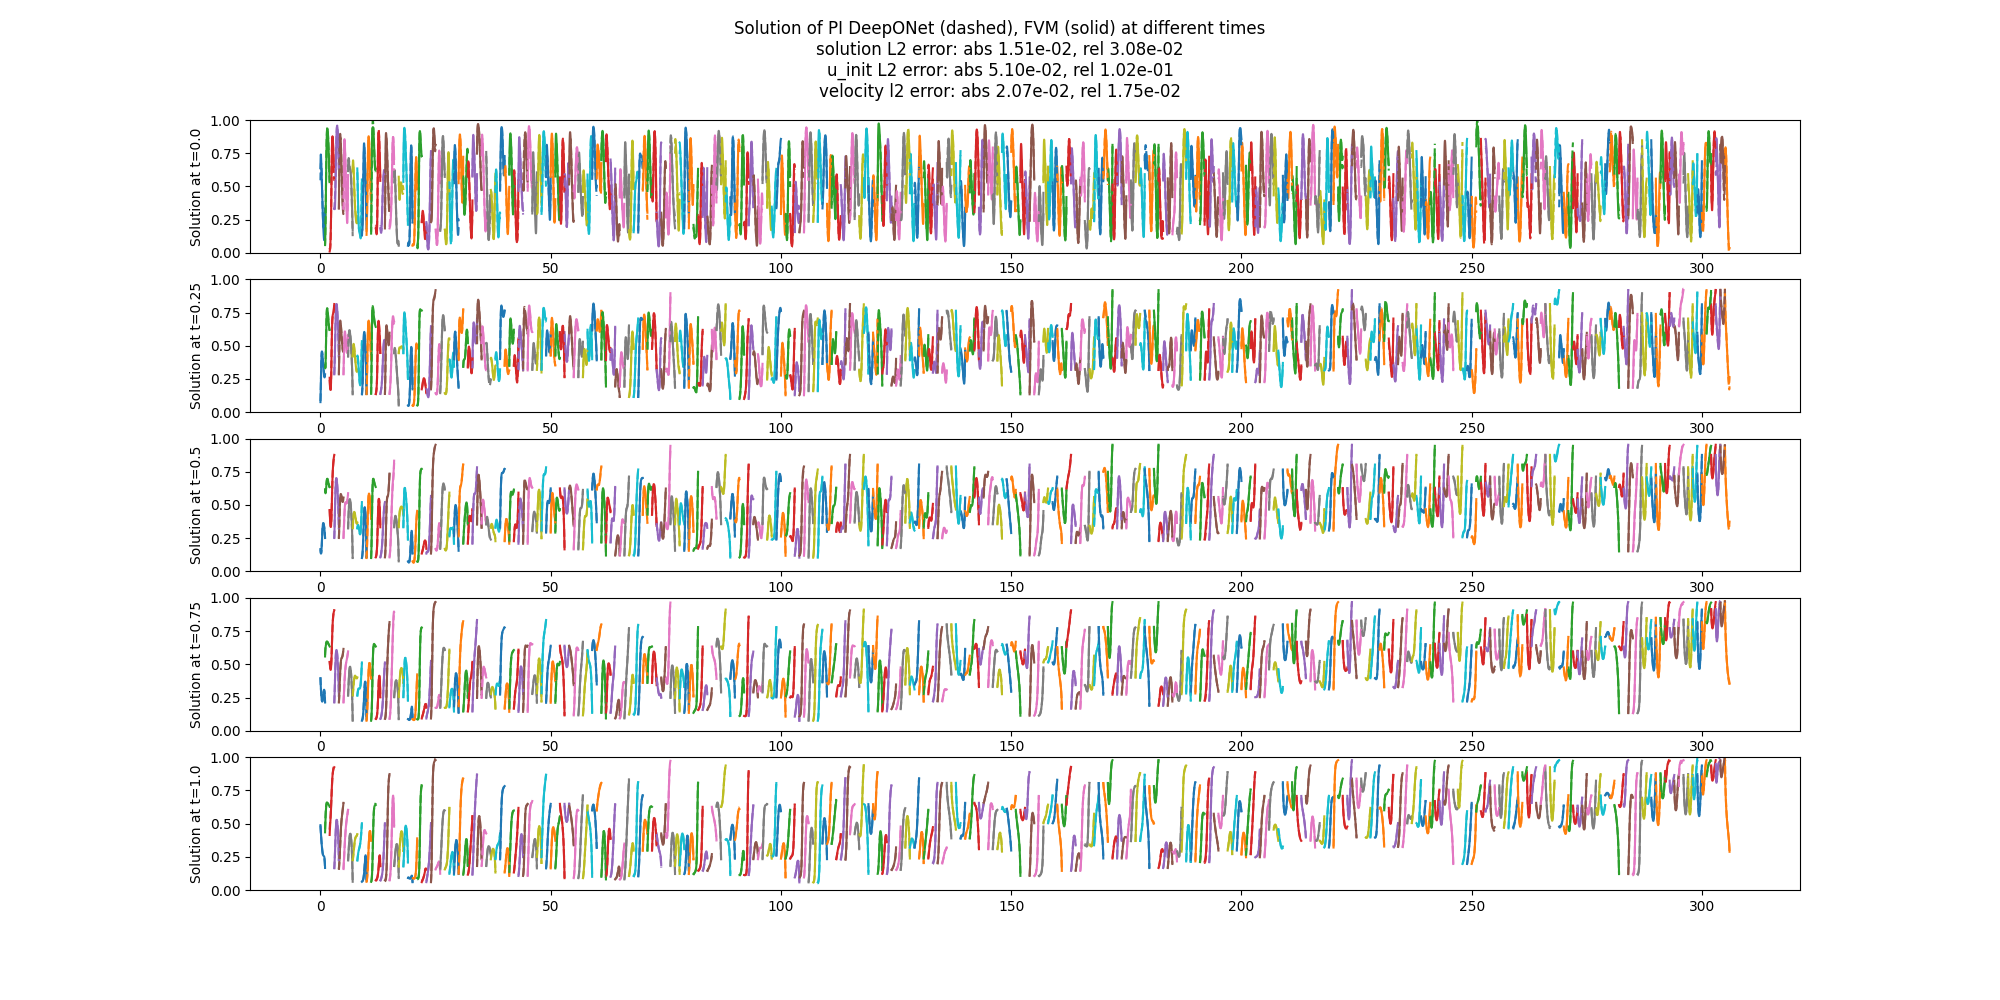

In [151]:
VMIN = 0
VMAX = 1
n_edges = graph.ne
def plot_chain_graph_time_slice(v, tidx, ax, **kwargs):
    # Inflow edge
    ax.plot(np.linspace(0,1,101), v[0][:, tidx], **kwargs)
    # Outflow edge
    ax.plot(np.linspace(0,1,101) + graph.ne - 1, v[graph.ne-1][:, tidx], **kwargs)
    # Inner edges
    for i in range(n_edges - 2):
        ax.plot(np.linspace(0,1,101) + i + 1, v[i + 1][:, tidx], **kwargs)
    ax.set_ylim([0,1])
    #ax.set_xlabel('Space')
    #ax.set_ylabel('Value')
    return ax
fig = plt.figure(figsize=(20,10));
#fig.suptitle('Comparison of FVM solution (solid) and PI DeepONet solution (dashed)')
jlist = [0,25,50,75,100]#, 50,27, 100]

for j, jidx in enumerate(jlist):
    #print('j: ', j)
    #print('jidx: ', jidx)
    ax = fig.add_subplot(len(jlist),1, j+1)
    ax = plot_chain_graph_time_slice(v_small, jidx, ax, linestyle='-', label='FVM')
    plt.gca().set_prop_cycle(None)
    ax = plot_chain_graph_time_slice(v_pred, jidx, ax, linestyle='--', label='PI DeepONet')

    ax.set_ylabel(f'Solution at t={jidx/100}');

t1 = f'Solution of PI DeepONet (dashed), FVM (solid) at different times\nsolution L2 error: abs {l2_abs_error:4.2e}, rel {l2_rel_error:4.2e}\n'
t2 = f'u_init L2 error: abs {u_init_L2_abs_error:4.2e}, rel {u_init_L2_rel_error:4.2e}\n'
t3 = f'velocity l2 error: abs {vel_abs_error:4.2e}, rel {vel_rel_error:4.2e}'
fig.suptitle(t1 + t2 + t3)
# plt.savefig(f'./figs/inverse_graph_{graph.ne}_edges_comparison.png', dpi=200)

Text(0.5, 0.98, 'Solution of PI DeepONet (dashed), FVM (solid) at different times, L2 error abs 2.34e-02, L2 error rel 4.49e-02_mode_2')

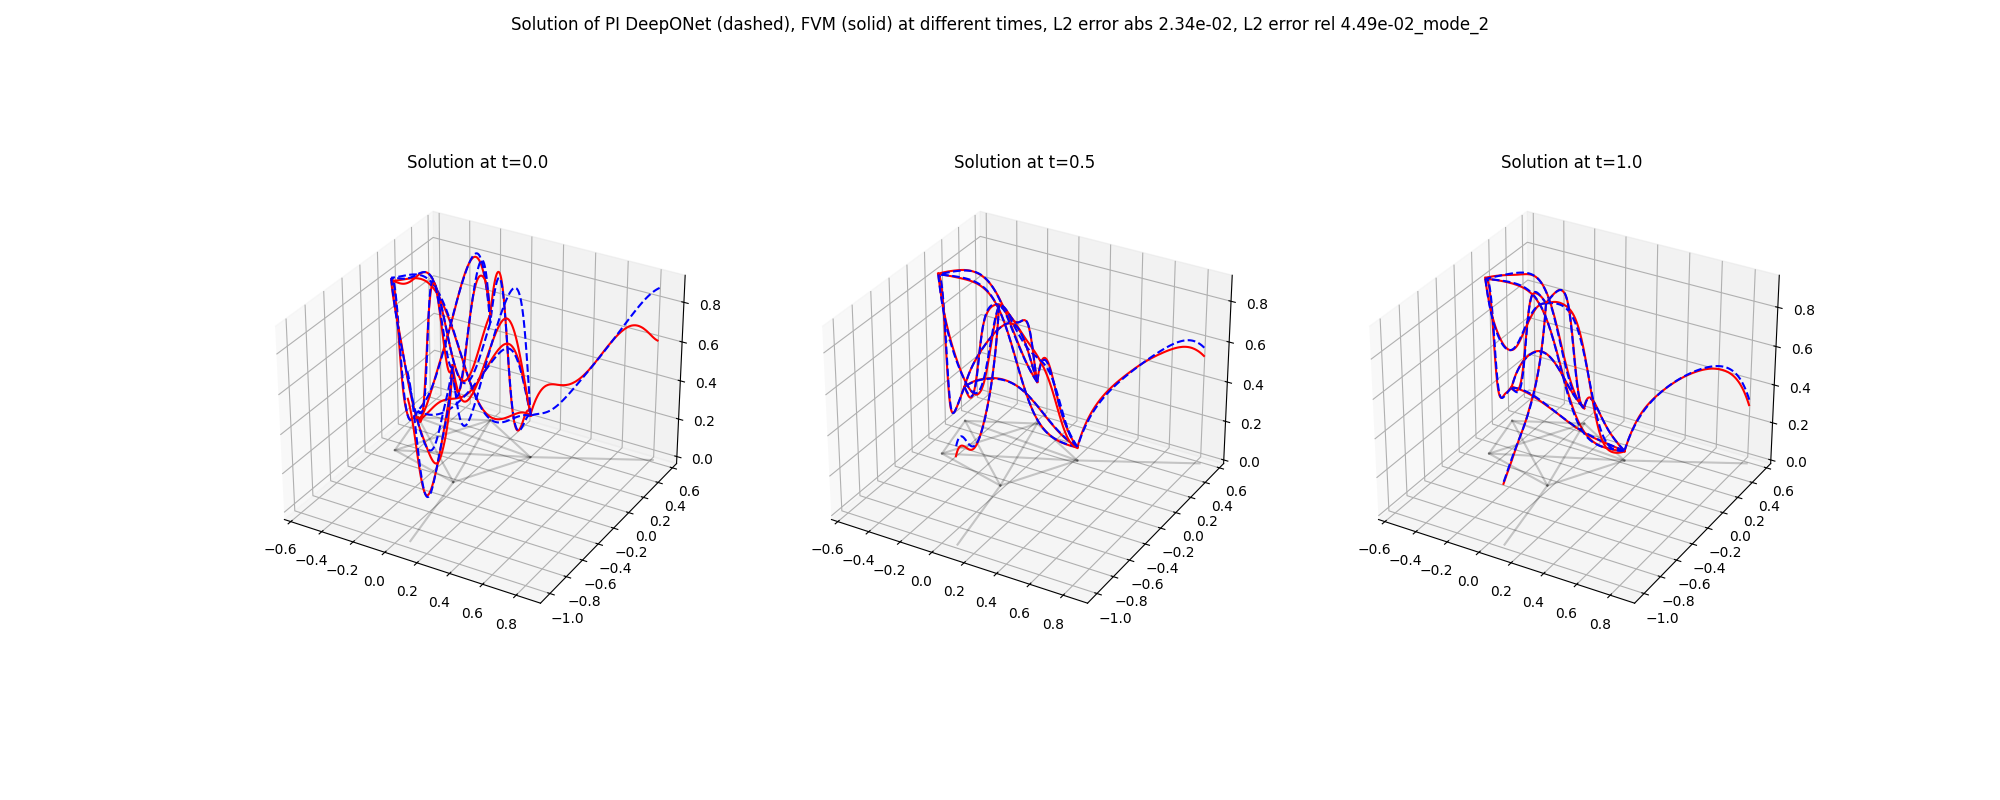

In [114]:

#jlist = [0,25, 50,27, 100]
jlist = [0,50,100]#, 50,27, 100]

X = np.linspace(0, 1, 101).reshape((-1, 1))
xy_list = [graph.pos[e[0]] + X * (graph.pos[e[1]] - graph.pos[e[0]]) for e in graph.E]

fig = plt.figure(figsize=(20,8), clear=True)
#fig, ax = plt.subplots(1, len(jlist), projection='3d')
ee = np.ones_like(xy_list[0][:, 0])
for jidx, j in enumerate(jlist):
    ax = fig.add_subplot(1, len(jlist), jidx+1, projection='3d')
    for i, e in enumerate(graph.E):
        ax.plot(xy_list[i][:, 0], xy_list[i][:, 1], 0*ee, 'k-', alpha=0.2)
        ax.plot(xy_list[i][:, 0], xy_list[i][:, 1], v_pred[i, :, j], 'r')
        ax.plot(xy_list[i][:, 0], xy_list[i][:, 1], v_small[i, :, j], 'b--')
        ax.set_title(f'Solution at t={j/100}');
#fig.suptitle('PI DeepONet (solid), FVM (dashed)')

        

fig.suptitle(f'Solution of PI DeepONet (dashed), FVM (solid) at different times, L2 error abs {l2_abs_error:4.2e}, L2 error rel {l2_rel_error:4.2e}_mode_{mode}')
#plt.savefig(f'./figs/inverse_graph_{graph.ne}_edges_comparison3d.png', dpi=200)

Text(0.5, 0.98, 'Difference between PI DeepONet and FVM solution at different times, L2 error abs 2.34e-02, L2 error rel 4.49e-02_mode_2')

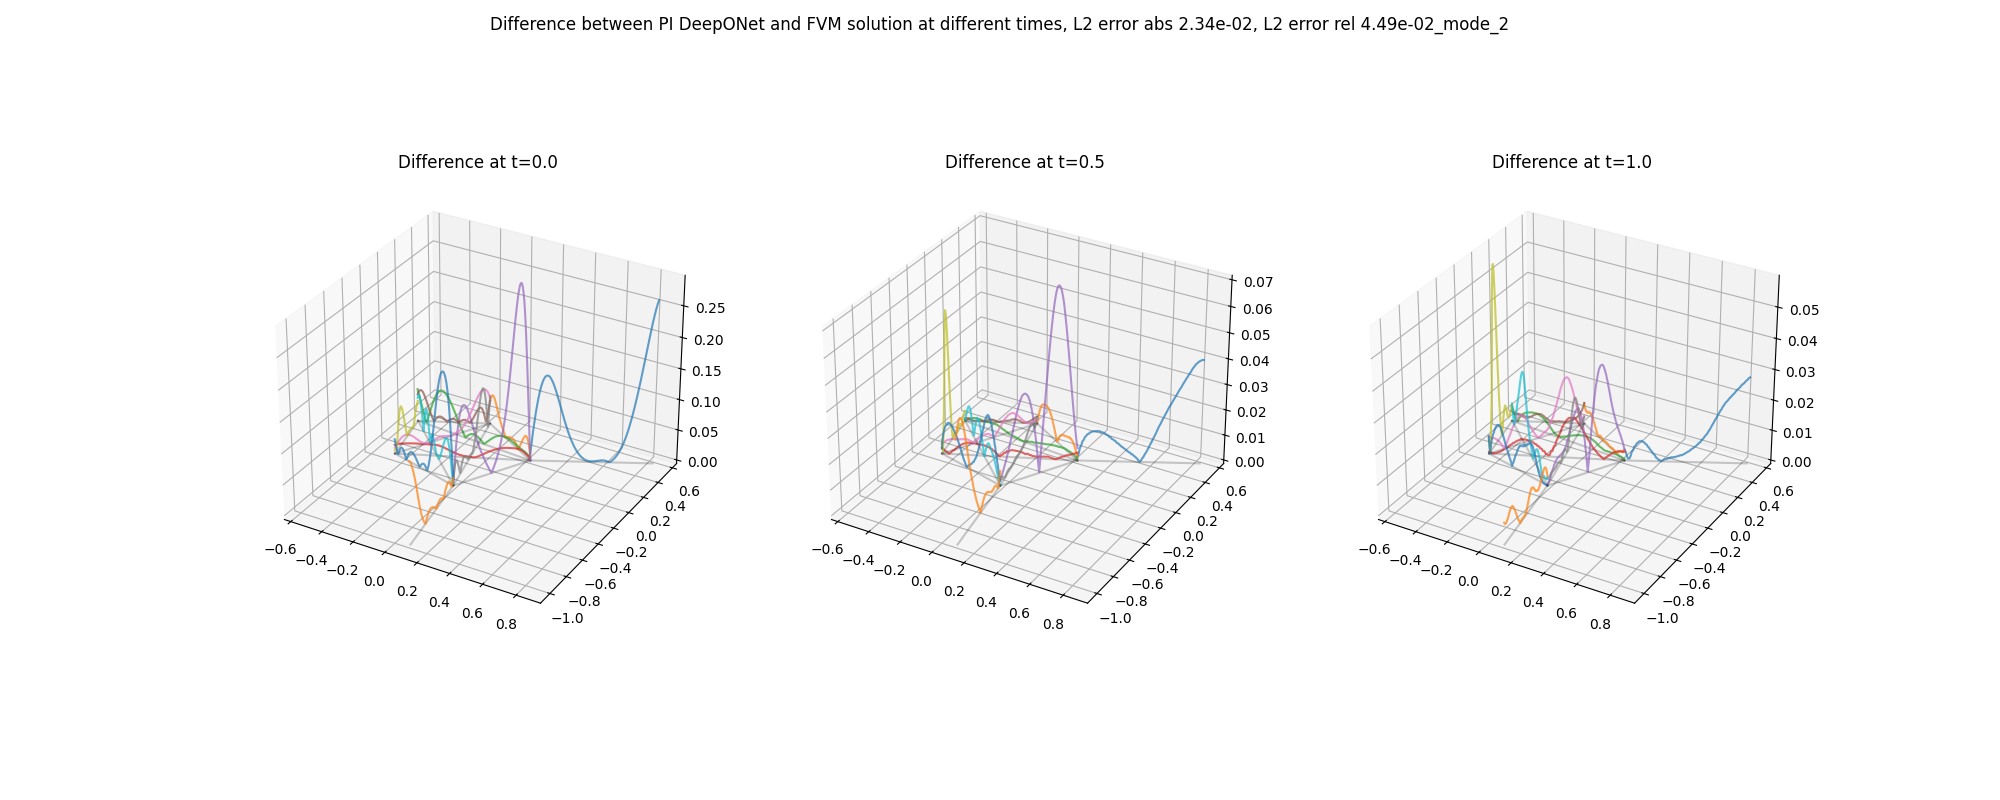

In [115]:

#jlist = [0,25, 50,27, 100]
jlist = [0,50,100]#, 50,27, 100]

X = np.linspace(0, 1, 101).reshape((-1, 1))
xy_list = [graph.pos[e[0]] + X * (graph.pos[e[1]] - graph.pos[e[0]]) for e in graph.E]

fig = plt.figure(figsize=(20,8), clear=True)
#fig, ax = plt.subplots(1, len(jlist), projection='3d')
ee = np.ones_like(xy_list[0][:, 0])
for jidx, j in enumerate(jlist):
    ax = fig.add_subplot(1, len(jlist), jidx+1, projection='3d')
    for i, e in enumerate(graph.E):
        ax.plot(xy_list[i][:, 0], xy_list[i][:, 1], 0*ee, 'k-', alpha=0.2)
        ax.plot(xy_list[i][:, 0], xy_list[i][:, 1], jnp.abs(v_pred[i, :, j] - v_small[i, :, j]), alpha=0.7)
        #ax.plot(xy_list[i][:, 0], xy_list[i][:, 1], v_small[i, :, j], 'b--')
        ax.set_title(f'Difference at t={j/100}');
#fig.suptitle('PI DeepONet (solid), FVM (dashed)')

        

fig.suptitle(f'Difference between PI DeepONet and FVM solution at different times, L2 error abs {l2_abs_error:4.2e}, L2 error rel {l2_rel_error:4.2e}_mode_{mode}')
#plt.savefig(f'./figs/inverse_graph_{graph.ne}_edges_difference3d.png', dpi=200)